# Jellyfish Image Classification Model

The goal of this project is to make a high accuracy AI model for jellyfish image classifiaction.

Dataset used in this project : [Jellyfish Image Dataset](https://www.kaggle.com/datasets/anshtanwar/jellyfish-types)

Taewan (Tay) Ham / Yonsei university

## Data Pre-processing

In [1]:
import numpy as np
import pandas as pd
import os

label_list = os.listdir('.\jellyfish\Train_Test_Valid\Train')

data_divs = []
label_divs = []
paths = []

for dirname, _, filenames in os.walk('./jellyfish/Train_Test_Valid'):
    for filename in filenames:
        file_path = dirname + '/' + filename
        paths.append(file_path)

        # train, test, valid datasets
        if '\\Train\\' in file_path:
            data_divs.append('train')
        elif '\\test\\' in file_path:
            data_divs.append('test')
        elif '\\valid\\' in file_path:
            data_divs.append('valid')

        # categorize jellyfish
        if 'barrel_jellyfish' in file_path:
            label_divs.append('Barrel Jellyfish')
        elif 'blue_jellyfish' in file_path:
            label_divs.append('Blue Jellyfish')
        elif 'compass_jellyfish' in file_path:
            label_divs.append('Compass Jellyfish')
        elif 'lions_mane_jellyfish' in file_path:
            label_divs.append('Lions Mane Jellyfish')
        elif 'mauve_stinger_jellyfish' in file_path:
            label_divs.append('Mauve Stinger Jellyfish')
        elif 'Moon_jellyfish' in file_path:
            label_divs.append('Moon Jellyfish')

df = pd.DataFrame({'path':paths, 'data': data_divs, 'label':label_divs})
df.head()

,path,data,label
0,./jellyfish/Train_Test_Valid\test\barrel_jelly...,test,Barrel Jellyfish
1,./jellyfish/Train_Test_Valid\test\barrel_jelly...,test,Barrel Jellyfish
2,./jellyfish/Train_Test_Valid\test\barrel_jelly...,test,Barrel Jellyfish
3,./jellyfish/Train_Test_Valid\test\barrel_jelly...,test,Barrel Jellyfish
4,./jellyfish/Train_Test_Valid\test\barrel_jelly...,test,Barrel Jellyfish


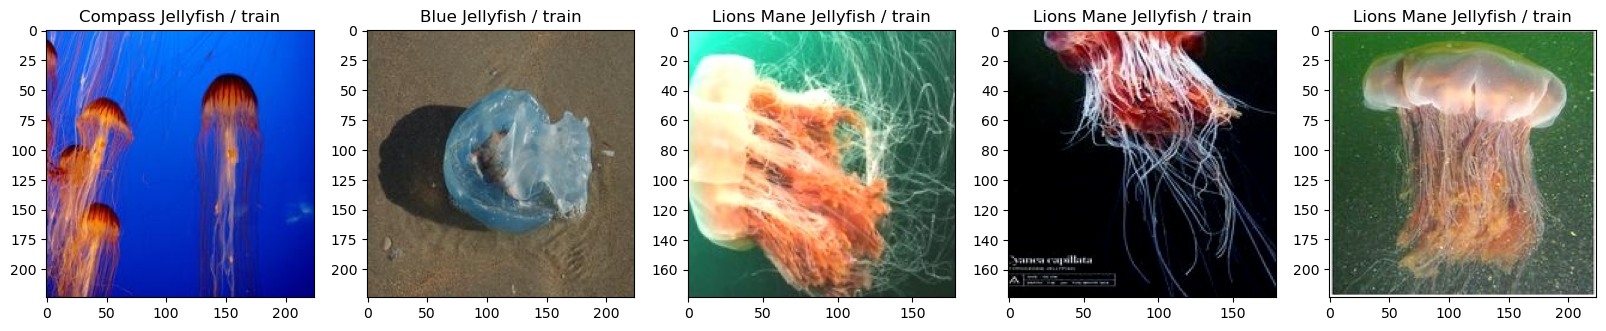

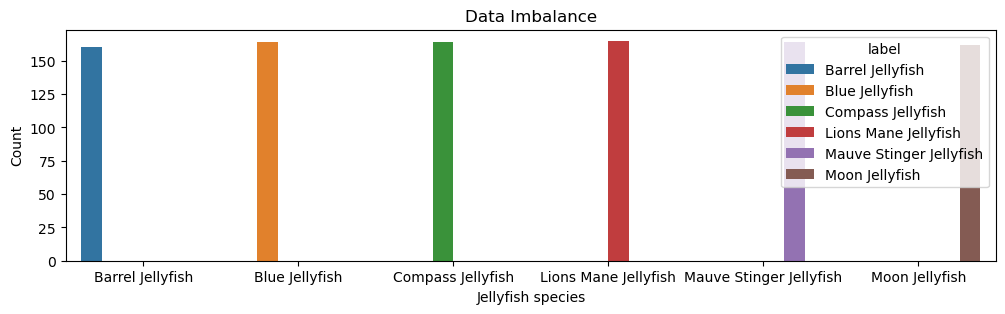

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random

fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 8))
for n in range(5):
    i = random.randrange(1, 900)  # Pick 5 random jellyfish image
    axs[n].imshow(cv2.cvtColor(cv2.imread(df.loc[i, 'path']), cv2.COLOR_BGR2RGB))
    axs[n].set_title(df.loc[i, 'label'] + f" / {df.loc[i, 'data']}")

# Data Imbalance
plt.figure(figsize=(12,3))
sns.countplot(x=df.loc[:, 'label'], hue=df.loc[:, 'label'])
plt.title("Data Imbalance")
plt.xlabel("Jellyfish species")
plt.ylabel("Count")
plt.show()

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Classifying Train-Test-Valid data
tr_df = df[df['data'] == 'train'] 
test_df = df[df['data'] == 'test']
val_df = df[df['data'] == 'valid']

In [4]:
# Data Augmentation
tr_gen = ImageDataGenerator(horizontal_flip=True, 
                            vertical_flip=True, 
                            rotation_range=20.0, 
                            brightness_range=(0.7, 1.3),
                            rescale=1./255)

val_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

img_size = 299  # Xception:299, DenseNet, ConvNeXtLarge:224, 
tr_flow_gen = tr_gen.flow_from_dataframe(dataframe=tr_df,
                                         x_col='path',
                                         y_col='label',
                                         target_size=(img_size, img_size),
                                         batch_size=32,
                                         class_mode='categorical',
                                         shuffle=True)

val_flow_gen = val_gen.flow_from_dataframe(dataframe=val_df,
                                           x_col='path',
                                           y_col='label',
                                           target_size=(img_size, img_size),
                                           class_mode='categorical',
                                           batch_size=32,
                                           shuffle=False)

Found 900 validated image filenames belonging to 6 classes.
Found 39 validated image filenames belonging to 6 classes.


In this project, three different models are used: [Xception](https://keras.io/api/applications/xception/), [DenseNet201](https://keras.io/api/applications/densenet/), [ConvNeXtLarge](https://keras.io/api/applications/convnext/).

## Model 1. Xception

In [5]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

input_tensor = Input(shape=(img_size,img_size,3))
base_model_Xception = Xception(
    weights = "imagenet",  # Load weights pre-trained on ImageNet.
    input_tensor = input_tensor,
    include_top = False,
)

x = base_model_Xception.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
output = Dense(6, activation='softmax')(x)
model_Xception = Model(inputs=input_tensor, outputs=output)

model_Xception.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]'

 Conv2D)                                                                                          
                                                                                                  
 block4_sepconv1_bn (BatchN  (None, 37, 37, 728)          2912      ['block4_sepconv1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block4_sepconv2_act (Activ  (None, 37, 37, 728)          0         ['block4_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block4_sepconv2 (Separable  (None, 37, 37, 728)          536536    ['block4_sepconv2_act[0][0]'] 
 Conv2D)                                                                                          
          

                                                                     'add_3[0][0]']               
                                                                                                  
 block7_sepconv1_act (Activ  (None, 19, 19, 728)          0         ['add_4[0][0]']               
 ation)                                                                                           
                                                                                                  
 block7_sepconv1 (Separable  (None, 19, 19, 728)          536536    ['block7_sepconv1_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block7_sepconv1_bn (BatchN  (None, 19, 19, 728)          2912      ['block7_sepconv1[0][0]']     
 ormalization)                                                                                    
          

 block9_sepconv3 (Separable  (None, 19, 19, 728)          536536    ['block9_sepconv3_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block9_sepconv3_bn (BatchN  (None, 19, 19, 728)          2912      ['block9_sepconv3[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 add_7 (Add)                 (None, 19, 19, 728)          0         ['block9_sepconv3_bn[0][0]',  
                                                                     'add_6[0][0]']               
                                                                                                  
 block10_sepconv1_act (Acti  (None, 19, 19, 728)          0         ['add_7[0][0]']               
 vation)  

                                                                                                  
 block12_sepconv2_bn (Batch  (None, 19, 19, 728)          2912      ['block12_sepconv2[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 block12_sepconv3_act (Acti  (None, 19, 19, 728)          0         ['block12_sepconv2_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 block12_sepconv3 (Separabl  (None, 19, 19, 728)          536536    ['block12_sepconv3_act[0][0]']
 eConv2D)                                                                                         
                                                                                                  
 block12_s

In [6]:
model_Xception.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Reduce learning rate if validation loss does not reduce within 10 repetition
lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='min', verbose=1, min_lr=1e-7)
# Early Stop if validation loss does not decrease within 20 repetition (Prevent Overfitting)
st_cb = EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=1)

hist_Xception = model_Xception.fit(tr_flow_gen, epochs=200, validation_data=val_flow_gen, callbacks=[lr_cb, st_cb])

Epoch 1/200


29/29 [==============================] - 269s 9s/step - loss: 0.6750 - accuracy: 0.7722 - val_loss: 2.4877 - val_accuracy: 0.4615 - lr: 0.0010
Epoch 2/200
29/29 [==============================] - 244s 8s/step - loss: 0.2638 - accuracy: 0.9144 - val_loss: 3.0965 - val_accuracy: 0.5641 - lr: 0.0010
Epoch 3/200
29/29 [==============================] - 241s 8s/step - loss: 0.1931 - accuracy: 0.9344 - val_loss: 1.8890 - val_accuracy: 0.6923 - lr: 0.0010
Epoch 4/200
29/29 [==============================] - 238s 8s/step - loss: 0.1857 - accuracy: 0.9433 - val_loss: 3.2906 - val_accuracy: 0.4615 - lr: 0.0010
Epoch 5/200
29/29 [==============================] - 236s 8s/step - loss: 0.1326 - accuracy: 0.9533 - val_loss: 1.1660 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 6/200
29/29 [==============================] - 237s 8s/step - loss: 0.1382 - accuracy: 0.9544 - val_loss: 3.7465 - val_accuracy: 0.5128 - lr: 0.0010
Epoch 7/200
29/29 [==============================] - 237s 8s/step - 

In [7]:
test_flow_gen = test_gen.flow_from_dataframe(dataframe=test_df,
                                                   x_col='path',
                                                   y_col='label',
                                                   target_size=(img_size, img_size),
                                                   class_mode='categorical',
                                                   batch_size=32,
                                                   shuffle=False)

result = model_Xception.evaluate(test_flow_gen)

# Print Test Result
print('loss : ', result[0], ', accuracy : ', result[1])

Found 40 validated image filenames belonging to 6 classes.
2/2 [==============================] - 3s 566ms/step - loss: 0.7098 - accuracy: 0.8500
loss :  0.7098431587219238 , accuracy :  0.8500000238418579


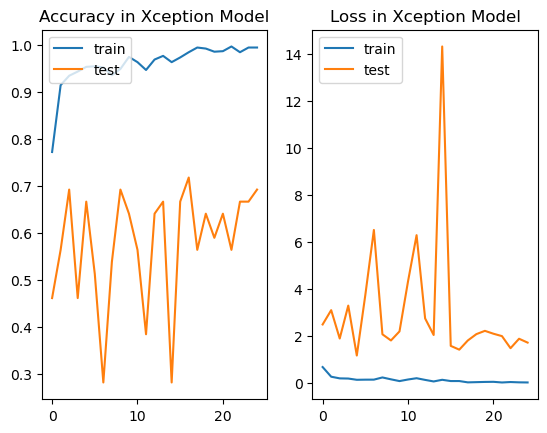

In [8]:
# Plot Accuracy
plt.subplot(121)
plt.plot(hist_Xception.history['accuracy'])
plt.plot(hist_Xception.history['val_accuracy'])
plt.title('Accuracy in Xception Model')
plt.legend(['train','test'], loc='upper left')

# Plot Loss
plt.subplot(122)
plt.plot(hist_Xception.history['loss'])
plt.plot(hist_Xception.history['val_loss'])
plt.title('Loss in Xception Model')
plt.legend(['train','test'], loc='upper left')

In [9]:
# Save Model
model_Xception.save('202402070825_Xception.keras')

## Model 2. DenseNet201

In [10]:
img_size = 224  # Xception:229, DenseNet, ConvNeXtLarge:224, 
tr_flow_gen = tr_gen.flow_from_dataframe(dataframe=tr_df,
                                         x_col='path',
                                         y_col='label',
                                         target_size=(img_size, img_size),
                                         batch_size=32,
                                         class_mode='categorical',
                                         shuffle=True)

val_flow_gen = val_gen.flow_from_dataframe(dataframe=val_df,
                                           x_col='path',
                                           y_col='label',
                                           target_size=(img_size, img_size),
                                           class_mode='categorical',
                                           batch_size=32,
                                           shuffle=False)

Found 900 validated image filenames belonging to 6 classes.
Found 39 validated image filenames belonging to 6 classes.


In [11]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

input_tensor = Input(shape=(img_size,img_size,3))
base_model_DenseNet201 = DenseNet201(
    weights = "imagenet",  # Load weights pre-trained on ImageNet.
    input_tensor = input_tensor,
    include_top = False,
)

x = base_model_DenseNet201.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
output = Dense(6, activation='softmax')(x)
model_DenseNet201 = Model(inputs=input_tensor, outputs=output)

model_DenseNet201.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']    

 conv2_block4_0_bn (BatchNo  (None, 56, 56, 160)          640       ['conv2_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block4_0_relu (Activ  (None, 56, 56, 160)          0         ['conv2_block4_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_block4_1_conv (Conv2  (None, 56, 56, 128)          20480     ['conv2_block4_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv2_block4_1_bn (BatchNo  (None, 56, 56, 128)          512       ['conv2_block4_1_conv[0][0]'] 
 rmalizati

 rmalization)                                                                                     
                                                                                                  
 conv3_block1_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block1_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block1_2_conv (Conv2  (None, 28, 28, 32)           36864     ['conv3_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block1_concat (Conca  (None, 28, 28, 160)          0         ['pool2_pool[0][0]',          
 tenate)                                                             'conv3_block1_2_conv[0][0]'] 
          

 conv3_block5_1_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block5_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block5_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block5_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block5_2_conv (Conv2  (None, 28, 28, 32)           36864     ['conv3_block5_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block5_concat (Conca  (None, 28, 28, 288)          0         ['conv3_block4_concat[0][0]', 
 tenate)  

                                                                                                  
 conv3_block9_1_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block9_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block9_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block9_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block9_2_conv (Conv2  (None, 28, 28, 32)           36864     ['conv3_block9_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_blo

 pool3_pool (AveragePooling  (None, 14, 14, 256)          0         ['pool3_conv[0][0]']          
 2D)                                                                                              
                                                                                                  
 conv4_block1_0_bn (BatchNo  (None, 14, 14, 256)          1024      ['pool3_pool[0][0]']          
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_0_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_1_conv (Conv2  (None, 14, 14, 128)          32768     ['conv4_block1_0_relu[0][0]'] 
 D)       

                                                                                                  
 conv4_block4_concat (Conca  (None, 14, 14, 384)          0         ['conv4_block3_concat[0][0]', 
 tenate)                                                             'conv4_block4_2_conv[0][0]'] 
                                                                                                  
 conv4_block5_0_bn (BatchNo  (None, 14, 14, 384)          1536      ['conv4_block4_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block5_0_relu (Activ  (None, 14, 14, 384)          0         ['conv4_block5_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block8_concat (Conca  (None, 14, 14, 512)          0         ['conv4_block7_concat[0][0]', 
 tenate)                                                             'conv4_block8_2_conv[0][0]'] 
                                                                                                  
 conv4_block9_0_bn (BatchNo  (None, 14, 14, 512)          2048      ['conv4_block8_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block9_0_relu (Activ  (None, 14, 14, 512)          0         ['conv4_block9_0_bn[0][0]']   
 ation)                                                                                           
          

 conv4_block12_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block12_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block12_concat (Conc  (None, 14, 14, 640)          0         ['conv4_block11_concat[0][0]',
 atenate)                                                            'conv4_block12_2_conv[0][0]']
                                                                                                  
 conv4_block13_0_bn (BatchN  (None, 14, 14, 640)          2560      ['conv4_block12_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block13_0_relu (Acti  (None, 14, 14, 640)          0         ['conv4_block13_0_bn[0][0]']  
 vation)  

                                                                                                  
 conv4_block16_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block16_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block16_concat (Conc  (None, 14, 14, 768)          0         ['conv4_block15_concat[0][0]',
 atenate)                                                            'conv4_block16_2_conv[0][0]']
                                                                                                  
 conv4_block17_0_bn (BatchN  (None, 14, 14, 768)          3072      ['conv4_block16_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_blo

 vation)                                                                                          
                                                                                                  
 conv4_block20_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block20_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block20_concat (Conc  (None, 14, 14, 896)          0         ['conv4_block19_concat[0][0]',
 atenate)                                                            'conv4_block20_2_conv[0][0]']
                                                                                                  
 conv4_block21_0_bn (BatchN  (None, 14, 14, 896)          3584      ['conv4_block20_concat[0][0]']
 ormalization)                                                                                    
          

 conv4_block24_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block24_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block24_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block24_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block24_concat (Conc  (None, 14, 14, 1024)         0         ['conv4_block23_concat[0][0]',
 atenate)                                                            'conv4_block24_2_conv[0][0]']
                                                                                                  
 conv4_block25_0_bn (BatchN  (None, 14, 14, 1024)         4096      ['conv4_block24_concat[0][0]']
 ormalizat

                                                                                                  
 conv4_block28_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block28_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block28_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block28_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block28_concat (Conc  (None, 14, 14, 1152)         0         ['conv4_block27_concat[0][0]',
 atenate)                                                            'conv4_block28_2_conv[0][0]']
                                                                                                  
 conv4_blo

 ormalization)                                                                                    
                                                                                                  
 conv4_block32_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block32_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block32_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block32_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block32_concat (Conc  (None, 14, 14, 1280)         0         ['conv4_block31_concat[0][0]',
 atenate)                                                            'conv4_block32_2_conv[0][0]']
          

 conv4_block36_1_bn (BatchN  (None, 14, 14, 128)          512       ['conv4_block36_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block36_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block36_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block36_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block36_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block36_concat (Conc  (None, 14, 14, 1408)         0         ['conv4_block35_concat[0][0]',
 atenate) 

                                                                                                  
 conv4_block40_1_bn (BatchN  (None, 14, 14, 128)          512       ['conv4_block40_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block40_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block40_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block40_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block40_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_blo

 2D)                                                                                              
                                                                                                  
 conv4_block44_1_bn (BatchN  (None, 14, 14, 128)          512       ['conv4_block44_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block44_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block44_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block44_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block44_1_relu[0][0]']
 2D)                                                                                              
          

 conv4_block48_1_conv (Conv  (None, 14, 14, 128)          225280    ['conv4_block48_0_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block48_1_bn (BatchN  (None, 14, 14, 128)          512       ['conv4_block48_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block48_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block48_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block48_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block48_1_relu[0][0]']
 2D)      

 D)                                                                                               
                                                                                                  
 conv5_block3_concat (Conca  (None, 7, 7, 992)            0         ['conv5_block2_concat[0][0]', 
 tenate)                                                             'conv5_block3_2_conv[0][0]'] 
                                                                                                  
 conv5_block4_0_bn (BatchNo  (None, 7, 7, 992)            3968      ['conv5_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block4_0_relu (Activ  (None, 7, 7, 992)            0         ['conv5_block4_0_bn[0][0]']   
 ation)                                                                                           
          

 conv5_block7_2_conv (Conv2  (None, 7, 7, 32)             36864     ['conv5_block7_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block7_concat (Conca  (None, 7, 7, 1120)           0         ['conv5_block6_concat[0][0]', 
 tenate)                                                             'conv5_block7_2_conv[0][0]'] 
                                                                                                  
 conv5_block8_0_bn (BatchNo  (None, 7, 7, 1120)           4480      ['conv5_block7_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block8_0_relu (Activ  (None, 7, 7, 1120)           0         ['conv5_block8_0_bn[0][0]']   
 ation)   

                                                                                                  
 conv5_block11_2_conv (Conv  (None, 7, 7, 32)             36864     ['conv5_block11_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block11_concat (Conc  (None, 7, 7, 1248)           0         ['conv5_block10_concat[0][0]',
 atenate)                                                            'conv5_block11_2_conv[0][0]']
                                                                                                  
 conv5_block12_0_bn (BatchN  (None, 7, 7, 1248)           4992      ['conv5_block11_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_blo

 vation)                                                                                          
                                                                                                  
 conv5_block15_2_conv (Conv  (None, 7, 7, 32)             36864     ['conv5_block15_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block15_concat (Conc  (None, 7, 7, 1376)           0         ['conv5_block14_concat[0][0]',
 atenate)                                                            'conv5_block15_2_conv[0][0]']
                                                                                                  
 conv5_block16_0_bn (BatchN  (None, 7, 7, 1376)           5504      ['conv5_block15_concat[0][0]']
 ormalization)                                                                                    
          

 conv5_block19_1_relu (Acti  (None, 7, 7, 128)            0         ['conv5_block19_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block19_2_conv (Conv  (None, 7, 7, 32)             36864     ['conv5_block19_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block19_concat (Conc  (None, 7, 7, 1504)           0         ['conv5_block18_concat[0][0]',
 atenate)                                                            'conv5_block19_2_conv[0][0]']
                                                                                                  
 conv5_block20_0_bn (BatchN  (None, 7, 7, 1504)           6016      ['conv5_block19_concat[0][0]']
 ormalizat

                                                                                                  
 conv5_block23_1_relu (Acti  (None, 7, 7, 128)            0         ['conv5_block23_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block23_2_conv (Conv  (None, 7, 7, 32)             36864     ['conv5_block23_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block23_concat (Conc  (None, 7, 7, 1632)           0         ['conv5_block22_concat[0][0]',
 atenate)                                                            'conv5_block23_2_conv[0][0]']
                                                                                                  
 conv5_blo

 ormalization)                                                                                    
                                                                                                  
 conv5_block27_1_relu (Acti  (None, 7, 7, 128)            0         ['conv5_block27_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block27_2_conv (Conv  (None, 7, 7, 32)             36864     ['conv5_block27_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block27_concat (Conc  (None, 7, 7, 1760)           0         ['conv5_block26_concat[0][0]',
 atenate)                                                            'conv5_block27_2_conv[0][0]']
          

 conv5_block31_1_bn (BatchN  (None, 7, 7, 128)            512       ['conv5_block31_1_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block31_1_relu (Acti  (None, 7, 7, 128)            0         ['conv5_block31_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block31_2_conv (Conv  (None, 7, 7, 32)             36864     ['conv5_block31_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block31_concat (Conc  (None, 7, 7, 1888)           0         ['conv5_block30_concat[0][0]',
 atenate) 

In [12]:
model_DenseNet201.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Reduce learning rate if validation loss does not reduce within 10 repetition
lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='min', verbose=1, min_lr=1e-7)
# Early Stop if validation loss does not decrease within 20 repetition (Prevent Overfitting)
st_cb = EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=1)

hist_DenseNet201 = model_DenseNet201.fit(tr_flow_gen, epochs=200, validation_data=val_flow_gen, callbacks=[lr_cb, st_cb])

Epoch 1/200
29/29 [==============================] - 235s 6s/step - loss: 1.0057 - accuracy: 0.6500 - val_loss: 38.1725 - val_accuracy: 0.1795 - lr: 0.0010
Epoch 2/200
29/29 [==============================] - 160s 5s/step - loss: 0.8242 - accuracy: 0.7256 - val_loss: 37.6378 - val_accuracy: 0.1282 - lr: 0.0010
Epoch 3/200
29/29 [==============================] - 161s 6s/step - loss: 0.6761 - accuracy: 0.7733 - val_loss: 24.7687 - val_accuracy: 0.2821 - lr: 0.0010
Epoch 4/200
29/29 [==============================] - 159s 5s/step - loss: 0.5332 - accuracy: 0.8178 - val_loss: 10.8103 - val_accuracy: 0.4103 - lr: 0.0010
Epoch 5/200
29/29 [==============================] - 179s 6s/step - loss: 0.4173 - accuracy: 0.8556 - val_loss: 21.8879 - val_accuracy: 0.2564 - lr: 0.0010
Epoch 6/200
29/29 [==============================] - 174s 6s/step - loss: 0.4027 - accuracy: 0.8678 - val_loss: 8.4827 - val_accuracy: 0.4103 - lr: 0.0010
Epoch 7/200
29/29 [==============================] - 167s 6s/step

Epoch 51/200
29/29 [==============================] - 162s 6s/step - loss: 0.0356 - accuracy: 0.9900 - val_loss: 1.9043 - val_accuracy: 0.7179 - lr: 2.5000e-04
Epoch 52/200
29/29 [==============================] - 165s 6s/step - loss: 0.0161 - accuracy: 0.9944 - val_loss: 1.8522 - val_accuracy: 0.7179 - lr: 2.5000e-04
Epoch 53/200
29/29 [==============================] - ETA: 0s - loss: 0.0148 - accuracy: 0.9956
Epoch 53: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
29/29 [==============================] - 163s 6s/step - loss: 0.0148 - accuracy: 0.9956 - val_loss: 1.6097 - val_accuracy: 0.7692 - lr: 2.5000e-04
Epoch 53: early stopping


In [13]:
test_flow_gen = test_gen.flow_from_dataframe(dataframe=test_df,
                                                   x_col='path',
                                                   y_col='label',
                                                   target_size=(img_size, img_size),
                                                   class_mode='categorical',
                                                   batch_size=32,
                                                   shuffle=False)

result = model_DenseNet201.evaluate(test_flow_gen)

# Print Test Result
print('loss : ', result[0], ', accuracy : ', result[1])

Found 40 validated image filenames belonging to 6 classes.
2/2 [==============================] - 2s 689ms/step - loss: 0.5394 - accuracy: 0.8500
loss :  0.539370059967041 , accuracy :  0.8500000238418579


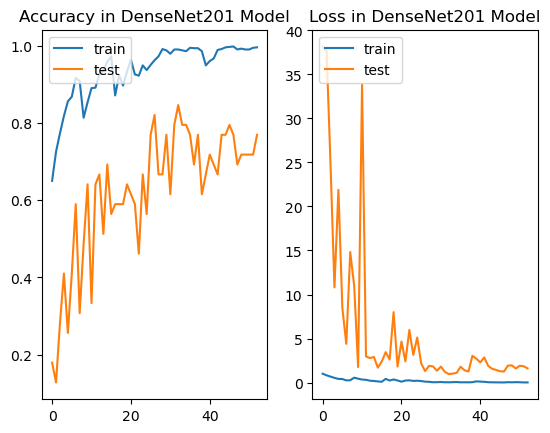

In [14]:
# Plot Validation Accuracy
plt.subplot(121)
plt.plot(hist_DenseNet201.history['accuracy'])
plt.plot(hist_DenseNet201.history['val_accuracy'])
plt.title('Accuracy in DenseNet201 Model')
plt.legend(['train','test'], loc='upper left')

# Plot Loss
plt.subplot(122)
plt.plot(hist_DenseNet201.history['loss'])
plt.plot(hist_DenseNet201.history['val_loss'])
plt.title('Loss in DenseNet201 Model')
plt.legend(['train','test'], loc='upper left')

In [15]:
# Save Model
model_DenseNet201.save('202402072100_DenseNet.keras')

## Model 3. ConvNeXtLarge

In [16]:
from tensorflow.keras.applications import ConvNeXtLarge
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

input_tensor = Input(shape=(img_size,img_size,3))
base_model_ConvNeXtLarge = ConvNeXtLarge(
    weights = "imagenet",  # Load weights pre-trained on ImageNet.
    input_tensor = input_tensor,
    include_top = False,
)

x = base_model_ConvNeXtLarge.output
x = GlobalAveragePooling2D()(x)
x = Dropout(rate=0.5)(x)
output = Dense(6, activation='softmax')(x)
model_ConvNeXtLarge = Model(inputs=input_tensor, outputs=output)

model_ConvNeXtLarge.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 convnext_large_prestem_nor  (None, 224, 224, 3)          0         ['input_3[0][0]']             
 malization (Normalization)                                                                       
                                                                                                  
 convnext_large_stem (Seque  (None, 56, 56, 192)          9792      ['convnext_large_prestem_norma
 ntial)                                                             lization[0][0]']              
                                                                                            

 convnext_large_stage_0_blo  (None, 56, 56, 768)          0         ['convnext_large_stage_0_block
 ck_2_gelu (Activation)                                             _2_pointwise_conv_1[0][0]']   
                                                                                                  
 convnext_large_stage_0_blo  (None, 56, 56, 192)          147648    ['convnext_large_stage_0_block
 ck_2_pointwise_conv_2 (Den                                         _2_gelu[0][0]']               
 se)                                                                                              
                                                                                                  
 convnext_large_stage_0_blo  (None, 56, 56, 192)          192       ['convnext_large_stage_0_block
 ck_2_layer_scale (LayerSca                                         _2_pointwise_conv_2[0][0]']   
 le)                                                                                              
          

                                                                                                  
 convnext_large_stage_1_blo  (None, 28, 28, 384)          19200     ['tf.__operators__.add_4[0][0]
 ck_2_depthwise_conv (Conv2                                         ']                            
 D)                                                                                               
                                                                                                  
 convnext_large_stage_1_blo  (None, 28, 28, 384)          768       ['convnext_large_stage_1_block
 ck_2_layernorm (LayerNorma                                         _2_depthwise_conv[0][0]']     
 lization)                                                                                        
                                                                                                  
 convnext_large_stage_1_blo  (None, 28, 28, 1536)         591360    ['convnext_large_stage_1_block
 ck_2_poin

 se)                                                                                              
                                                                                                  
 convnext_large_stage_2_blo  (None, 14, 14, 768)          768       ['convnext_large_stage_2_block
 ck_1_layer_scale (LayerSca                                         _1_pointwise_conv_2[0][0]']   
 le)                                                                                              
                                                                                                  
 convnext_large_stage_2_blo  (None, 14, 14, 768)          0         ['convnext_large_stage_2_block
 ck_1_identity (Activation)                                         _1_layer_scale[0][0]']        
                                                                                                  
 tf.__operators__.add_7 (TF  (None, 14, 14, 768)          0         ['tf.__operators__.add_6[0][0]
 OpLambda)

                                                                                                  
 convnext_large_stage_2_blo  (None, 14, 14, 3072)         2362368   ['convnext_large_stage_2_block
 ck_4_pointwise_conv_1 (Den                                         _4_layernorm[0][0]']          
 se)                                                                                              
                                                                                                  
 convnext_large_stage_2_blo  (None, 14, 14, 3072)         0         ['convnext_large_stage_2_block
 ck_4_gelu (Activation)                                             _4_pointwise_conv_1[0][0]']   
                                                                                                  
 convnext_large_stage_2_blo  (None, 14, 14, 768)          2360064   ['convnext_large_stage_2_block
 ck_4_pointwise_conv_2 (Den                                         _4_gelu[0][0]']               
 se)      

                                                                     'convnext_large_stage_2_block
                                                                    _6_identity[0][0]']           
                                                                                                  
 convnext_large_stage_2_blo  (None, 14, 14, 768)          38400     ['tf.__operators__.add_12[0][0
 ck_7_depthwise_conv (Conv2                                         ]']                           
 D)                                                                                               
                                                                                                  
 convnext_large_stage_2_blo  (None, 14, 14, 768)          1536      ['convnext_large_stage_2_block
 ck_7_layernorm (LayerNorma                                         _7_depthwise_conv[0][0]']     
 lization)                                                                                        
          

                                                                                                  
 convnext_large_stage_2_blo  (None, 14, 14, 768)          768       ['convnext_large_stage_2_block
 ck_9_layer_scale (LayerSca                                         _9_pointwise_conv_2[0][0]']   
 le)                                                                                              
                                                                                                  
 convnext_large_stage_2_blo  (None, 14, 14, 768)          0         ['convnext_large_stage_2_block
 ck_9_identity (Activation)                                         _9_layer_scale[0][0]']        
                                                                                                  
 tf.__operators__.add_15 (T  (None, 14, 14, 768)          0         ['tf.__operators__.add_14[0][0
 FOpLambda)                                                         ]',                           
          

 alization)                                                                                       
                                                                                                  
 convnext_large_stage_2_blo  (None, 14, 14, 3072)         2362368   ['convnext_large_stage_2_block
 ck_12_pointwise_conv_1 (De                                         _12_layernorm[0][0]']         
 nse)                                                                                             
                                                                                                  
 convnext_large_stage_2_blo  (None, 14, 14, 3072)         0         ['convnext_large_stage_2_block
 ck_12_gelu (Activation)                                            _12_pointwise_conv_1[0][0]']  
                                                                                                  
 convnext_large_stage_2_blo  (None, 14, 14, 768)          2360064   ['convnext_large_stage_2_block
 ck_12_poi

 )                                                                                                
                                                                                                  
 tf.__operators__.add_20 (T  (None, 14, 14, 768)          0         ['tf.__operators__.add_19[0][0
 FOpLambda)                                                         ]',                           
                                                                     'convnext_large_stage_2_block
                                                                    _14_identity[0][0]']          
                                                                                                  
 convnext_large_stage_2_blo  (None, 14, 14, 768)          38400     ['tf.__operators__.add_20[0][0
 ck_15_depthwise_conv (Conv                                         ]']                           
 2D)                                                                                              
          

 convnext_large_stage_2_blo  (None, 14, 14, 3072)         0         ['convnext_large_stage_2_block
 ck_17_gelu (Activation)                                            _17_pointwise_conv_1[0][0]']  
                                                                                                  
 convnext_large_stage_2_blo  (None, 14, 14, 768)          2360064   ['convnext_large_stage_2_block
 ck_17_pointwise_conv_2 (De                                         _17_gelu[0][0]']              
 nse)                                                                                             
                                                                                                  
 convnext_large_stage_2_blo  (None, 14, 14, 768)          768       ['convnext_large_stage_2_block
 ck_17_layer_scale (LayerSc                                         _17_pointwise_conv_2[0][0]']  
 ale)                                                                                             
          

                                                                                                  
 convnext_large_stage_2_blo  (None, 14, 14, 768)          38400     ['tf.__operators__.add_25[0][0
 ck_20_depthwise_conv (Conv                                         ]']                           
 2D)                                                                                              
                                                                                                  
 convnext_large_stage_2_blo  (None, 14, 14, 768)          1536      ['convnext_large_stage_2_block
 ck_20_layernorm (LayerNorm                                         _20_depthwise_conv[0][0]']    
 alization)                                                                                       
                                                                                                  
 convnext_large_stage_2_blo  (None, 14, 14, 3072)         2362368   ['convnext_large_stage_2_block
 ck_20_poi

                                                                                                  
 convnext_large_stage_2_blo  (None, 14, 14, 768)          768       ['convnext_large_stage_2_block
 ck_22_layer_scale (LayerSc                                         _22_pointwise_conv_2[0][0]']  
 ale)                                                                                             
                                                                                                  
 convnext_large_stage_2_blo  (None, 14, 14, 768)          0         ['convnext_large_stage_2_block
 ck_22_identity (Activation                                         _22_layer_scale[0][0]']       
 )                                                                                                
                                                                                                  
 tf.__operators__.add_28 (T  (None, 14, 14, 768)          0         ['tf.__operators__.add_27[0][0
 FOpLambda

 ck_25_layernorm (LayerNorm                                         _25_depthwise_conv[0][0]']    
 alization)                                                                                       
                                                                                                  
 convnext_large_stage_2_blo  (None, 14, 14, 3072)         2362368   ['convnext_large_stage_2_block
 ck_25_pointwise_conv_1 (De                                         _25_layernorm[0][0]']         
 nse)                                                                                             
                                                                                                  
 convnext_large_stage_2_blo  (None, 14, 14, 3072)         0         ['convnext_large_stage_2_block
 ck_25_gelu (Activation)                                            _25_pointwise_conv_1[0][0]']  
                                                                                                  
 convnext_

 le)                                                                                              
                                                                                                  
 convnext_large_stage_3_blo  (None, 7, 7, 1536)           0         ['convnext_large_stage_3_block
 ck_0_identity (Activation)                                         _0_layer_scale[0][0]']        
                                                                                                  
 tf.__operators__.add_33 (T  (None, 7, 7, 1536)           0         ['convnext_large_downsampling_
 FOpLambda)                                                         block_2[0][0]',               
                                                                     'convnext_large_stage_3_block
                                                                    _0_identity[0][0]']           
                                                                                                  
 convnext_

Total params: 196239558 (748.59 MB)
Trainable params: 196239558 (748.59 MB)
Non-trainable params: 0 (0.00 Byte)
__________________________________________________________________________________________________


In [17]:
model_ConvNeXtLarge.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Reduce learning rate if validation loss does not reduce within 10 repetition
lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='min', verbose=1, min_lr=1e-7)
# Early Stop if validation loss does not decrease within 20 repetition (Prevent Overfitting)
st_cb = EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=1)

hist_ConvNeXtLarge = model_ConvNeXtLarge.fit(tr_flow_gen, epochs=200, validation_data=val_flow_gen, callbacks=[lr_cb, st_cb])

Epoch 1/200
29/29 [==============================] - 5694s 195s/step - loss: 3.1105 - accuracy: 0.1656 - val_loss: 1.8409 - val_accuracy: 0.1282 - lr: 0.0010
Epoch 2/200
29/29 [==============================] - 5329s 184s/step - loss: 2.1200 - accuracy: 0.1667 - val_loss: 1.8524 - val_accuracy: 0.1795 - lr: 0.0010
Epoch 3/200
29/29 [==============================] - 5410s 186s/step - loss: 1.9935 - accuracy: 0.1578 - val_loss: 1.8228 - val_accuracy: 0.1795 - lr: 0.0010
Epoch 4/200
29/29 [==============================] - 5424s 186s/step - loss: 1.9565 - accuracy: 0.1411 - val_loss: 1.8065 - val_accuracy: 0.1538 - lr: 0.0010
Epoch 5/200
29/29 [==============================] - 5440s 188s/step - loss: 1.9239 - accuracy: 0.1578 - val_loss: 1.8276 - val_accuracy: 0.1538 - lr: 0.0010
Epoch 6/200
29/29 [==============================] - 5351s 184s/step - loss: 1.9217 - accuracy: 0.1667 - val_loss: 1.9423 - val_accuracy: 0.1795 - lr: 0.0010
Epoch 7/200
29/29 [==============================] -

29/29 [==============================] - 5516s 190s/step - loss: 1.8123 - accuracy: 0.1400 - val_loss: 1.8080 - val_accuracy: 0.1282 - lr: 5.0000e-04
Epoch 52/200
29/29 [==============================] - 5385s 186s/step - loss: 1.8096 - accuracy: 0.1467 - val_loss: 1.7907 - val_accuracy: 0.1795 - lr: 5.0000e-04
Epoch 53/200
29/29 [==============================] - 5492s 189s/step - loss: 1.8125 - accuracy: 0.1656 - val_loss: 1.7911 - val_accuracy: 0.1795 - lr: 5.0000e-04
Epoch 54/200
29/29 [==============================] - 5526s 191s/step - loss: 1.8052 - accuracy: 0.1467 - val_loss: 1.7897 - val_accuracy: 0.1795 - lr: 5.0000e-04
Epoch 55/200
29/29 [==============================] - 5490s 189s/step - loss: 1.8106 - accuracy: 0.1500 - val_loss: 1.7925 - val_accuracy: 0.1795 - lr: 5.0000e-04
Epoch 56/200
29/29 [==============================] - 5466s 189s/step - loss: 1.8058 - accuracy: 0.1667 - val_loss: 1.7988 - val_accuracy: 0.1795 - lr: 5.0000e-04
Epoch 57/200
29/29 [===============

In [18]:
test_flow_gen = test_gen.flow_from_dataframe(dataframe=test_df,
                                                   x_col='path',
                                                   y_col='label',
                                                   target_size=(img_size, img_size),
                                                   class_mode='categorical',
                                                   batch_size=32,
                                                   shuffle=False)

result = model_ConvNeXtLarge.evaluate(test_flow_gen)
print('loss : ', result[0], ', accuracy : ', result[1])

Found 40 validated image filenames belonging to 6 classes.
2/2 [==============================] - 59s 15s/step - loss: 1.7994 - accuracy: 0.1750
loss :  1.7994167804718018 , accuracy :  0.17499999701976776


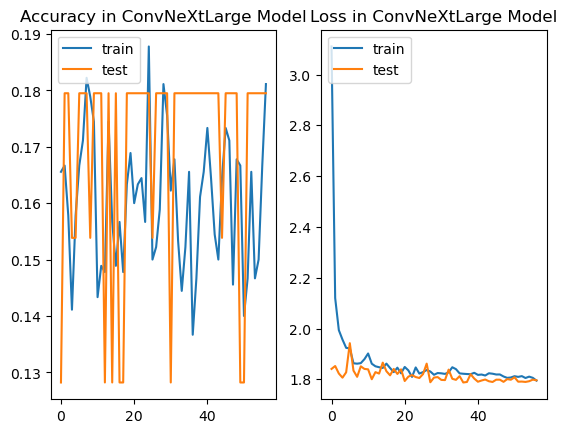

In [19]:
# Validation Accuracy
plt.subplot(121)
plt.plot(hist_ConvNeXtLarge.history['accuracy'])
plt.plot(hist_ConvNeXtLarge.history['val_accuracy'])
plt.title('Accuracy in ConvNeXtLarge Model')
plt.legend(['train','test'], loc='upper left')

# Loss
plt.subplot(122)
plt.plot(hist_ConvNeXtLarge.history['loss'])
plt.plot(hist_ConvNeXtLarge.history['val_loss'])
plt.title('Loss in ConvNeXtLarge Model')
plt.legend(['train','test'], loc='upper left')

In [20]:
# Save Model
model_ConvNeXtLarge.save('202402070825_ConvNeXtLarge.keras')

## Result

 Model         | Test Accuracy 
 :-            | :-:           
 **Xception**      | 0.85 
 **DenseNet201**   | 0.85 
 **ConvNeXtLarge** | 0.17 

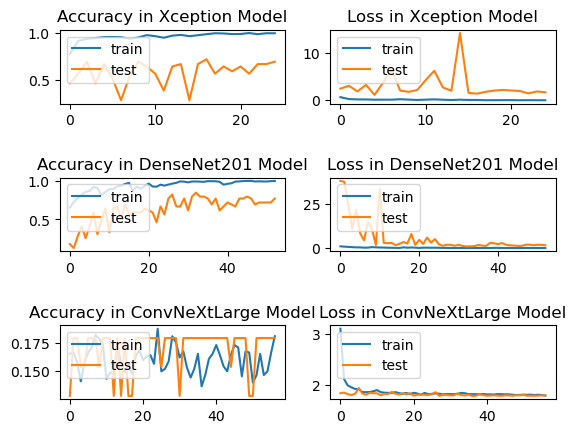

In [24]:
plt.subplots_adjust(hspace=1)

# Model 1 - Xception
# Validation Accuracy
plt.subplot(321)
plt.plot(hist_Xception.history['accuracy'])
plt.plot(hist_Xception.history['val_accuracy'])
plt.title('Accuracy in Xception Model')
plt.legend(['train','test'], loc='upper left')

# Loss
plt.subplot(322)
plt.plot(hist_Xception.history['loss'])
plt.plot(hist_Xception.history['val_loss'])
plt.title('Loss in Xception Model')
plt.legend(['train','test'], loc='upper left')

# Model 2 - DenseNet201
# Validation Accuracy
plt.subplot(323)
plt.plot(hist_DenseNet201.history['accuracy'])
plt.plot(hist_DenseNet201.history['val_accuracy'])
plt.title('Accuracy in DenseNet201 Model')
plt.legend(['train','test'], loc='upper left')

# Loss
plt.subplot(324)
plt.plot(hist_DenseNet201.history['loss'])
plt.plot(hist_DenseNet201.history['val_loss'])
plt.title('Loss in DenseNet201 Model')
plt.legend(['train','test'], loc='upper left')

# Validation Accuracy
plt.subplot(325)
plt.plot(hist_ConvNeXtLarge.history['accuracy'])
plt.plot(hist_ConvNeXtLarge.history['val_accuracy'])
plt.title('Accuracy in ConvNeXtLarge Model')
plt.legend(['train','test'], loc='upper left')

# Loss
plt.subplot(326)
plt.plot(hist_ConvNeXtLarge.history['loss'])
plt.plot(hist_ConvNeXtLarge.history['val_loss'])
plt.title('Loss in ConvNeXtLarge Model')
plt.legend(['train','test'], loc='upper left')